In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from data_downloader import GenerateTrainingData
from utils import date_today, gravity_law_commute_dist
import pickle
from epiweeks import Week
from tqdm import tqdm
from model import STAN

# Ensure reproducibility
RANDOM_SEED = 123
def seed_torch(seed=RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set environment variables
os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'


Using device: cuda


In [4]:
!nvidia-smi

Tue Dec 17 12:12:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P0             48W /  130W |    1324MiB /   6144MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
# save the data as a csv file
raw_data.to_csv('./data/state_covid_data.csv')


In [6]:
pop_data = pd.read_csv('./data/uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

In [7]:
pop_data.head()

,state_name,population,density,lat,lng
0,Alabama,4864630,139.010903,32.884042,-86.819800
1,Alaska,737979,88.192437,61.656278,-153.337221
2,Arizona,6949259,447.967160,33.705827,-111.575755
3,Arkansas,2990472,80.360237,35.134413,-92.377327
4,California,39140219,1257.655082,36.425895,-119.922270


In [8]:
raw_data.head()

,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277,Alabama,4864630,139.010903,32.884042,-86.8198
1,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226,Alabama,4864630,139.010903,32.884042,-86.8198
2,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317,Alabama,4864630,139.010903,32.884042,-86.8198
3,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249,Alabama,4864630,139.010903,32.884042,-86.8198
4,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346,Alabama,4864630,139.010903,32.884042,-86.8198


In [9]:
import torch

# Load the file
file_path = "./data/JHU_covid.pt"
jhu_covid_data = torch.load(file_path)

# Check the type and structure of the data
print(type(jhu_covid_data))

# If it's a dictionary, inspect the keys
if isinstance(jhu_covid_data, dict):
    print(jhu_covid_data.keys())

# Optionally, print a sample of the data to understand its structure
# e.g., if it's a dictionary with tensors
for key, value in jhu_covid_data.items():
    print(f"{key}: {value.shape if isinstance(value, torch.Tensor) else type(value)}")


<class 'dict'>
dict_keys(['features', 'feature_names', 'index'])
features: torch.Size([3342, 1143])
feature_names: <class 'list'>
index: <class 'pandas.core.indexes.base.Index'>


In [10]:
# Load the dataset
file_path = './data/merged_nhs_covid_data.csv'  # Update with the correct path
covid_data = pd.read_csv(file_path)

# Extract relevant features
features = ['hospitalCases', 'covidOccupiedMVBeds', 'newAdmissions', 'population']

# Normalize features using Min-Max scaling
covid_data[features] = covid_data[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create region IDs
region_ids = {region: idx for idx, region in enumerate(covid_data['areaName'].unique())}
covid_data['region_id'] = covid_data['areaName'].map(region_ids)

In [11]:
covid_data

,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,latitude,longitude,region_id
0,East of England,2020-04-01,0.000000,1400,0.103972,0.170931,334.0,75.0,2938.0,455.0,0.121317,151336,52.24,0.41,0
1,East of England,2020-04-02,0.097541,1584,0.104984,0.188332,372.0,71.0,3310.0,526.0,0.121317,151336,52.24,0.41,0
2,East of England,2020-04-03,0.132787,1776,0.114217,0.196520,350.0,85.0,3660.0,611.0,0.121317,151336,52.24,0.41,0
3,East of England,2020-04-04,0.140164,1939,0.123577,0.166837,268.0,70.0,3928.0,681.0,0.121317,151336,52.24,0.41,0
4,East of England,2020-04-05,0.179508,2159,0.154187,0.225179,281.0,91.0,4209.0,772.0,0.121317,151336,52.24,0.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259,South West,2022-09-08,0.001639,70521,0.037566,0.058342,349.0,7.0,1881291.0,11968.0,0.000000,151339,50.96,-3.22,6
6260,South West,2022-09-09,0.000820,70559,0.037566,0.038895,299.0,2.0,1881590.0,11970.0,0.000000,151339,50.96,-3.22,6
6261,South West,2022-09-10,0.000000,70609,0.035416,0.051177,359.0,4.0,1881949.0,11974.0,0.000000,151339,50.96,-3.22,6
6262,South West,2022-09-11,0.000000,70663,0.037693,0.055271,401.0,3.0,1882350.0,11977.0,0.000000,151339,50.96,-3.22,6


In [14]:
# Create a mapping from NHSER22NM to LAT and LONG
lat_long_mapping = {
    'London': (51.4923, -0.308660),
    'South East': (51.4341, -0.969570),
    'South West': (50.8112, -3.633430),
    'East of England': (52.1766, 0.425889),
    'North West': (53.8981, -2.657550),
    'Midlands': (52.7269, -1.458210),
    'North East and Yorkshire': (54.5378, -2.180390)
}

# Update the latitude and longitude columns in covid_data
covid_data['latitude'] = covid_data['areaName'].map(lambda x: lat_long_mapping[x][0])
covid_data['longitude'] = covid_data['areaName'].map(lambda x: lat_long_mapping[x][1])

# Verify the update
covid_data[['areaName', 'latitude', 'longitude']].head()

,areaName,latitude,longitude
0,East of England,52.1766,0.425889
1,East of England,52.1766,0.425889
2,East of England,52.1766,0.425889
3,East of England,52.1766,0.425889
4,East of England,52.1766,0.425889


In [15]:
# list the uniques in latitudes and longitudes
print(covid_data['latitude'].unique())
print(covid_data['longitude'].unique())

[52.1766 51.4923 52.7269 54.5378 53.8981 51.4341 50.8112]
[ 0.425889 -0.30866  -1.45821  -2.18039  -2.65755  -0.96957  -3.63343 ]


In [16]:
# Generate location similarity
loc_list = list(covid_data['areaName'].unique())
loc_dist_map = {}

for loc1 in loc_list:
    loc_dist_map[loc1] = {}
    for loc2 in loc_list:
        lat1, lon1 = covid_data[covid_data['areaName'] == loc1][['latitude', 'longitude']].values[0]
        lat2, lon2 = covid_data[covid_data['areaName'] == loc2][['latitude', 'longitude']].values[0]
        pop1, pop2 = covid_data[covid_data['areaName'] == loc1]['population'].values[0], covid_data[covid_data['areaName'] == loc2]['population'].values[0]
        loc_dist_map[loc1][loc2] = gravity_law_commute_dist(lat1, lon1, lat2, lon2, pop1, pop2, r=0.5)
        
        

loc_dist_map
    

{'East of England': {'East of England': 0.8329474327763531,
  'London': 1.0649049256563334,
  'Midlands': 1.1318220479346075,
  'North East and Yorkshire': 0.9765004175860679,
  'North West': 0.9136508489259392,
  'South East': 1.0683753188832377,
  'South West': 0.36298086197362106},
 'London': {'East of England': 0.8392543558680823,
  'London': 1.0729689064550343,
  'Midlands': 1.1403939228966942,
  'North East and Yorkshire': 0.9838965772760702,
  'North West': 0.9205713515348698,
  'South East': 1.0764662155965699,
  'South West': 0.3657305811918695},
 'Midlands': {'East of England': 0.8275006486475366,
  'London': 1.0579458657997212,
  'Midlands': 1.124433048434051,
  'North East and Yorkshire': 0.9701293163160907,
  'North West': 0.9076921773415014,
  'South East': 1.0613975984196744,
  'South West': 0.3606154586695135},
 'North East and Yorkshire': {'East of England': 0.8109650591678992,
  'London': 1.036805558014949,
  'Midlands': 1.1019644534037352,
  'North East and Yorkshire

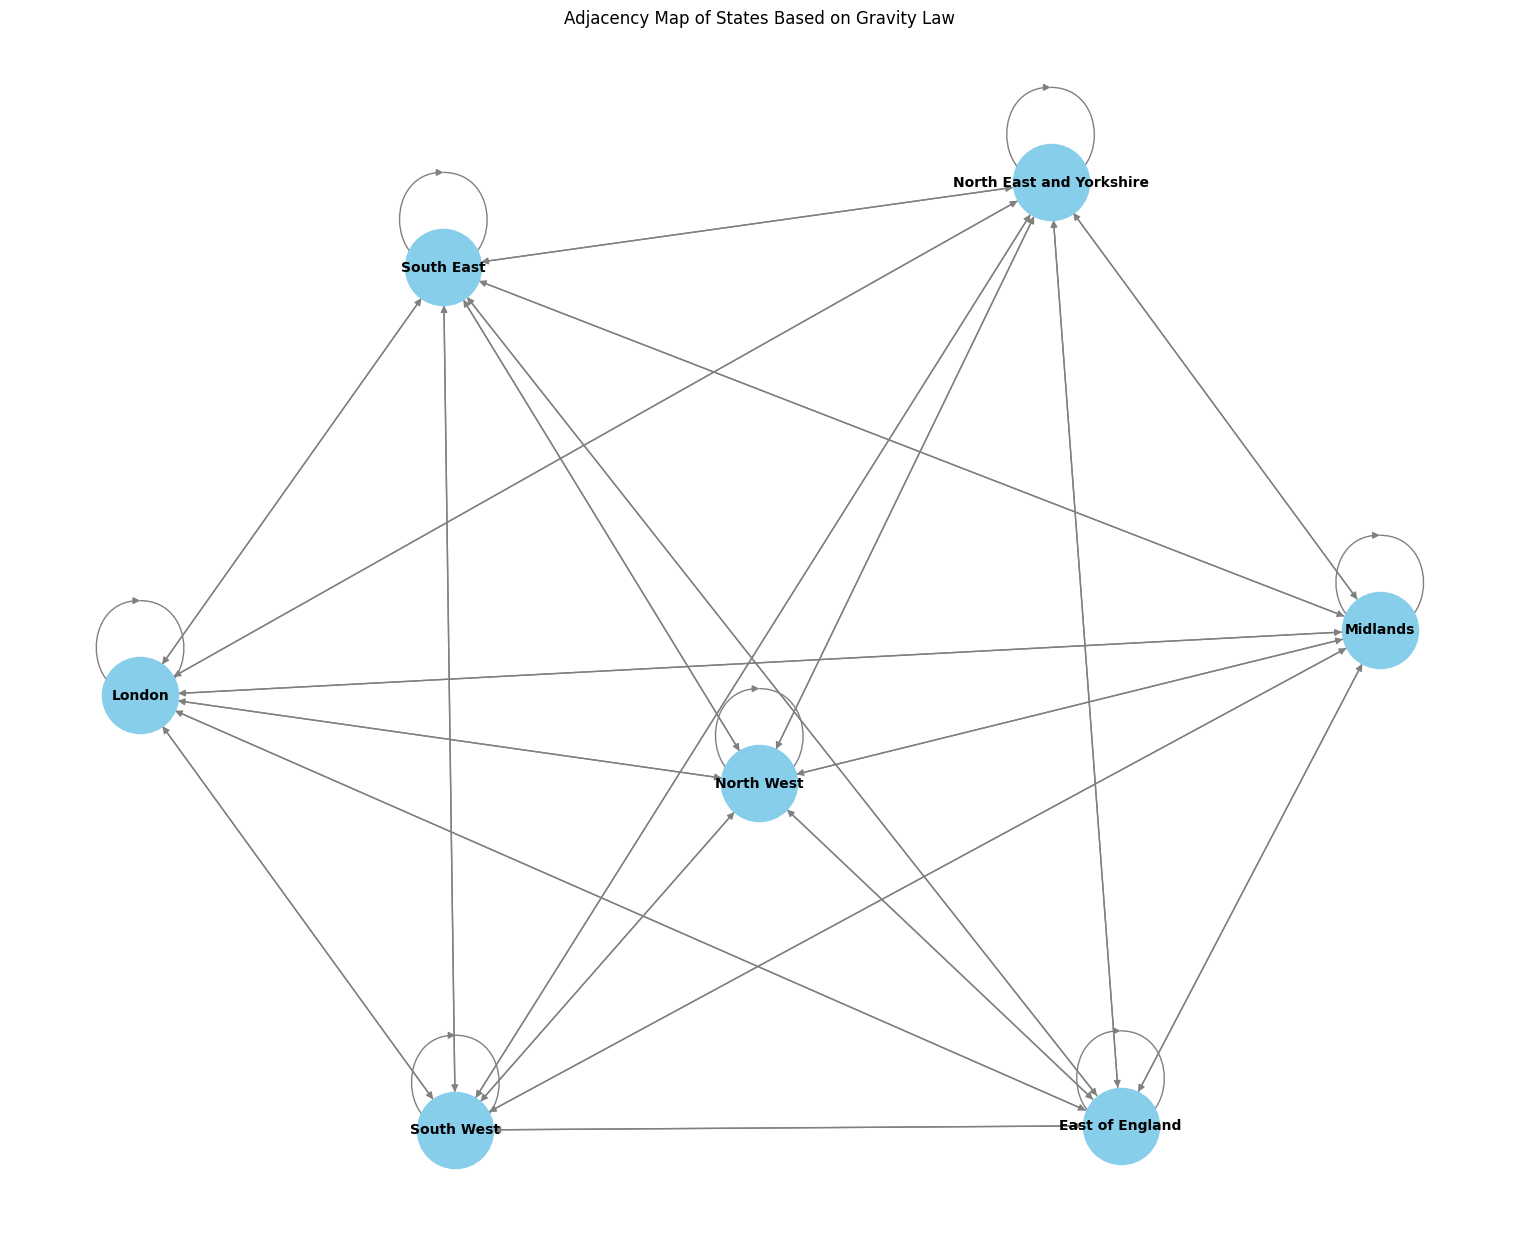

In [19]:
import networkx as nx

import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for state in loc_list:
    G.add_node(state)

# Add edges
for state, neighbors in loc_dist_map.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(state, neighbor, weight=weight)

# Plot the graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=RANDOM_SEED)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Adjacency Map of States Based on Gravity Law')
plt.show()

In [20]:
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

In [21]:
loc_dist_map

{'Alabama': {'Alabama': 99999.99999999999,
  'Alaska': 0.712213977364896,
  'Arizona': 4.698396259434448,
  'Arkansas': 4.258127278021843,
  'California': 0.6831863390239392,
  'Colorado': 13.82894158236376,
  'Connecticut': 6.045271677836252,
  'Delaware': 1.2507667550117934,
  'District of Columbia': 1.0729562129590724,
  'Florida': 1.2862349525276064,
  'Georgia': 2.668008093270385,
  'Hawaii': 0.9198672119925891,
  'Idaho': 1.6244016699415165,
  'Illinois': 1.9234010256631642,
  'Indiana': 6.247420986106947,
  'Iowa': 4.412319481592568,
  'Kansas': 3.821623789726329,
  'Kentucky': 22.510764001960286,
  'Louisiana': 48.38728880945531,
  'Maine': 1.439021711208862,
  'Maryland': 8.964416519381071,
  'Massachusetts': 5.216787377396814,
  'Michigan': 2.5503809397192154,
  'Minnesota': 14.205549978976938,
  'Mississippi': 4.39199642762415,
  'Missouri': 8.675656313241515,
  'Montana': 1.1613051897671864,
  'Nebraska': 2.081590297746719,
  'Nevada': 3.2627883290907578,
  'New Hampshire':

In [22]:
num_locations = len(loc_list)
print(f"Number of unique locations: {num_locations}")

Number of unique locations: 52


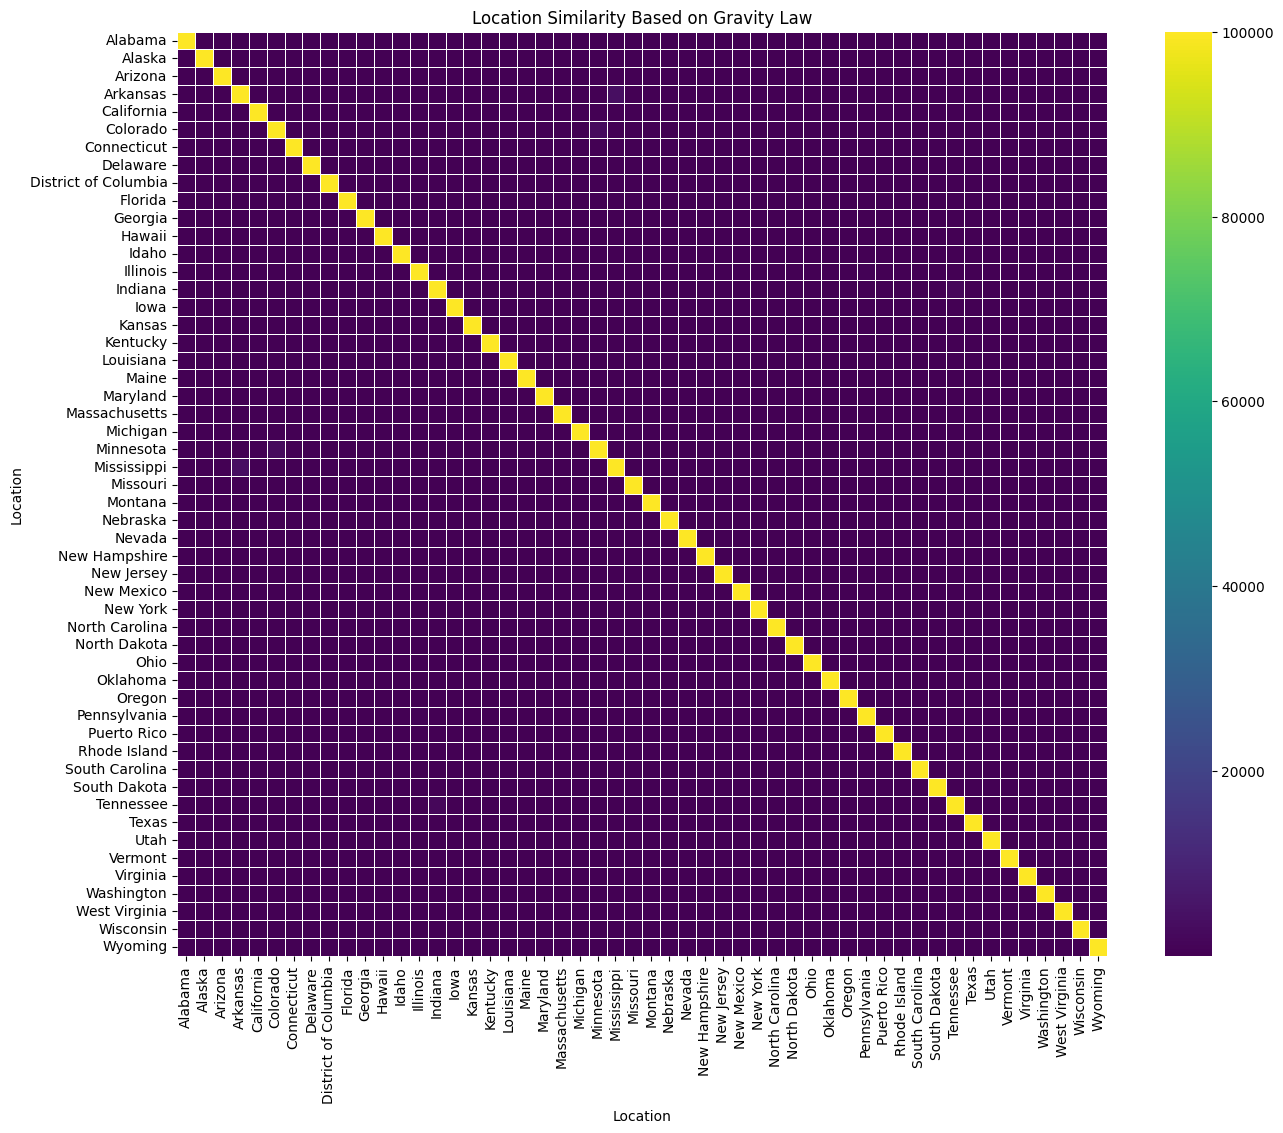

In [23]:
import seaborn as sns

# Convert loc_dist_map to a DataFrame for visualization
loc_dist_df = pd.DataFrame(loc_dist_map).fillna(0)

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(loc_dist_df, cmap='viridis', linewidths=.5)
plt.title('Location Similarity Based on Gravity Law')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()

In [24]:
#Generate Graph
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [25]:
# Initialize adjacency matrix
num_states = len(loc_list)
adj_matrix = np.zeros((num_states, num_states), dtype=np.float32)

# Create a mapping from state to index
state_to_index = {state: idx for idx, state in enumerate(loc_list)}

# Populate adjacency matrix based on adj_map
for each_loc in adj_map:
    i = state_to_index[each_loc]
    for each_loc2 in adj_map[each_loc]:
        j = state_to_index[each_loc2]
        adj_matrix[i][j] = 1  # Binary adjacency; set to 1 if connected

# Add self-loops to the adjacency matrix
adj_matrix += np.eye(num_states, dtype=np.float32)

# Normalize adjacency matrix
adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)

# Convert adjacency matrix to tensor
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32).to(device)

print(f"Adjacency Matrix Shape: {adj_matrix.shape}")

Adjacency Matrix Shape: torch.Size([52, 52])


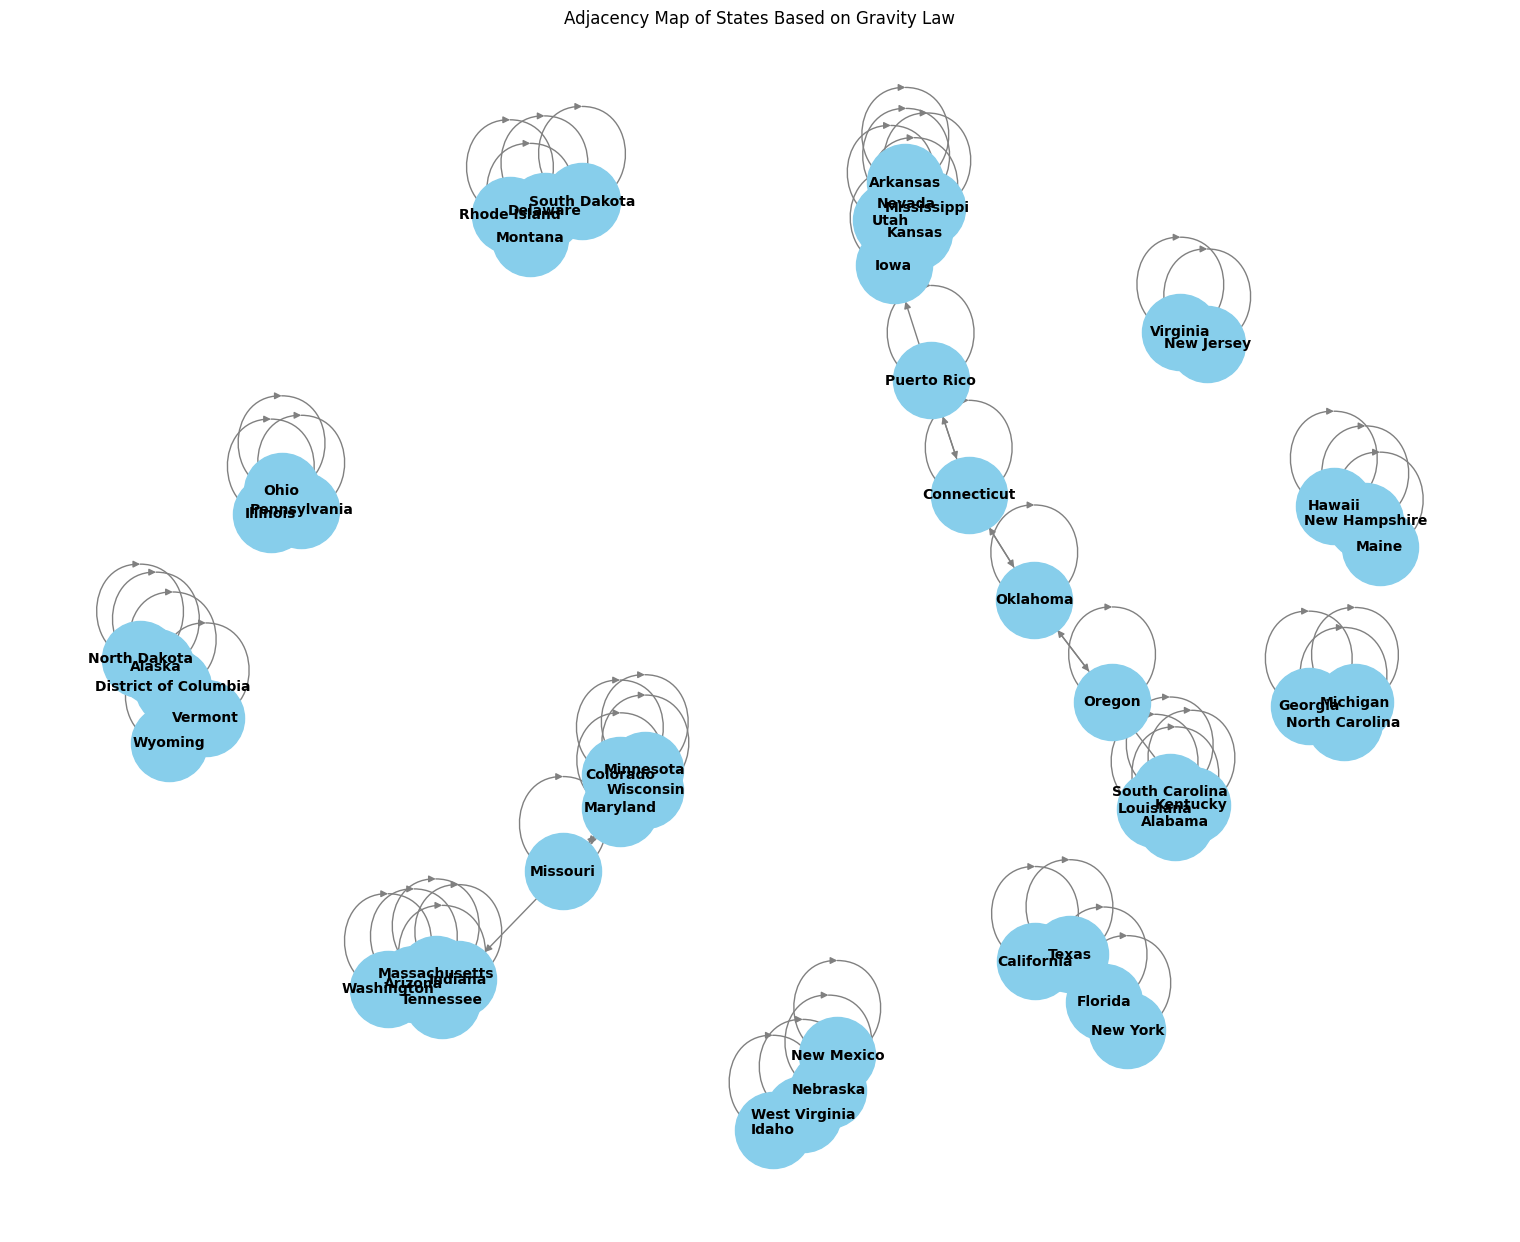

In [26]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for state in adj_map.keys():
    G.add_node(state)

# Add edges
for state, neighbors in adj_map.items():
    for neighbor in neighbors:
        G.add_edge(state, neighbor)

# Plot the graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=RANDOM_SEED)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Adjacency Map of States Based on Gravity Law')
plt.show()

In [27]:
loc_dist_map['Alabama']

{'Alabama': 99999.99999999999,
 'South Carolina': 108.59741605206139,
 'Louisiana': 48.38728880945531,
 'Kentucky': 22.510764001960286,
 'Minnesota': 14.205549978976938,
 'Colorado': 13.82894158236376,
 'Wisconsin': 10.795427380999408,
 'Oklahoma': 9.074260314573179,
 'Maryland': 8.964416519381071,
 'Oregon': 8.844877384003981,
 'Missouri': 8.675656313241515,
 'Tennessee': 6.516674814297488,
 'Indiana': 6.247420986106947,
 'Connecticut': 6.045271677836252,
 'Massachusetts': 5.216787377396814,
 'Arizona': 4.698396259434448,
 'Puerto Rico': 4.657146487291393,
 'Iowa': 4.412319481592568,
 'Mississippi': 4.39199642762415,
 'Arkansas': 4.258127278021843,
 'Kansas': 3.821623789726329,
 'Washington': 3.7263666616973925,
 'Utah': 3.6852680669627205,
 'Virginia': 3.4453625864353064,
 'Nevada': 3.2627883290907578,
 'New Jersey': 2.99873381795453,
 'Georgia': 2.668008093270385,
 'North Carolina': 2.604392803968267,
 'Michigan': 2.5503809397192154,
 'New Mexico': 2.2078808084657666,
 'Ohio': 2.134

In [54]:
import networkx as nx

g = nx.Graph()
g.add_edges_from(zip(rows, cols))

In [55]:
#Preprocess features

active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    new_cases.append(raw_data[raw_data['state'] == each_loc]['new_cases'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)

In [56]:
dR

array([[0.000e+00, 0.000e+00, 8.007e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.000e+00, 1.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 3.500e+01, 3.900e+01, ..., 5.780e+02, 5.270e+02,
        5.880e+02],
       ...,
       [0.000e+00, 0.000e+00, 1.900e+01, ..., 5.020e+02, 4.220e+02,
        8.190e+02],
       [0.000e+00, 2.500e+02, 1.580e+02, ..., 4.668e+03, 3.648e+03,
        4.340e+03],
       [0.000e+00, 0.000e+00, 1.400e+01, ..., 2.240e+02, 1.456e+03,
        1.525e+03]])

In [57]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [58]:
normalizer

{'S': {'Alabama': (4759029.751173709, 71167.74721304166),
  'Alaska': (730881.4835680751, 8226.040208832901),
  'Arizona': (6793526.305164319, 90914.51219403668),
  'Arkansas': (2932522.8732394367, 43435.91705978253),
  'California': (38577762.85446009, 344411.6100321278),
  'Colorado': (5457592.422535211, 58907.50238699691),
  'Connecticut': (3529485.5352112674, 17833.866882060942),
  'Delaware': (932989.4507042253, 7090.08432534675),
  'District of Columbia': (671850.2488262911, 3792.750329266508),
  'Florida': (20124997.75117371, 304091.5067699736),
  'Georgia': (10081885.96713615, 134790.09025702364),
  'Hawaii': (1414991.3286384977, 6242.78548451024),
  'Idaho': (1655817.7417840376, 27544.93535366438),
  'Illinois': (12571706.873239437, 158707.04389037227),
  'Indiana': (6537398.300469483, 76255.15785035763),
  'Iowa': (3062193.1502347416, 56587.04053286856),
  'Kansas': (2862237.0985915493, 39238.65271199116),
  'Kentucky': (4394318.201877934, 45438.738678639886),
  'Louisiana': 

In [59]:
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [60]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

normalize = True

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
if normalize:
    for i, each_loc in enumerate(loc_list):
        dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
        dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
        dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [ ]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [66]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [67]:
g

In [68]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [69]:
# Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'California'
cur_loc = loc_list.index(loc_name)

epoch_count = 50 if normalize else 300
scale = 0.1

for epoch in tqdm(range(epoch_count)):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    
    if normalize:
        phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    
    loss = (criterion(active_pred.squeeze(), train_yI[cur_loc].squeeze()) +
            criterion(recovered_pred.squeeze(), train_yR[cur_loc].squeeze()) +
            scale * criterion(phy_active.squeeze(), train_yI[cur_loc].squeeze()) +
            scale * criterion(phy_recover.squeeze(), train_yR[cur_loc].squeeze()))
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    if normalize:
        val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    
    val_loss = (criterion(val_active_pred.squeeze(), val_yI[cur_loc].squeeze()) +
                scale * criterion(val_phy_active.squeeze(), val_yI[cur_loc].squeeze()))
    
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss


  0%|          | 0/50 [00:01<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'ndata'

In [ ]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [ ]:
if normalize:
    print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
    print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.75
Estimated gamma in SIR model is 0.82


In [ ]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    if normalize:
        cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    else:
        cur_pred = test_pred_active[0, i, :].detach().cpu().numpy()
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [ ]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [ ]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

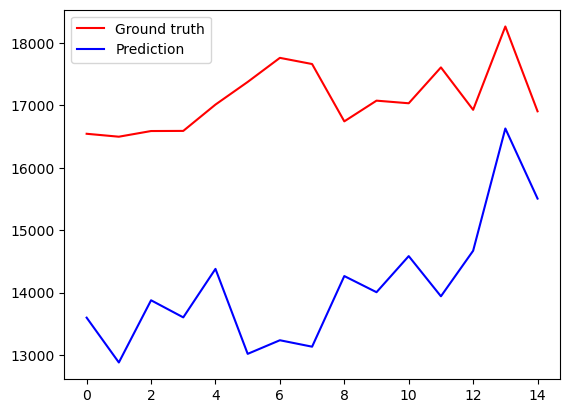

In [ ]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()

Using device: cuda
Number of unique locations: 52


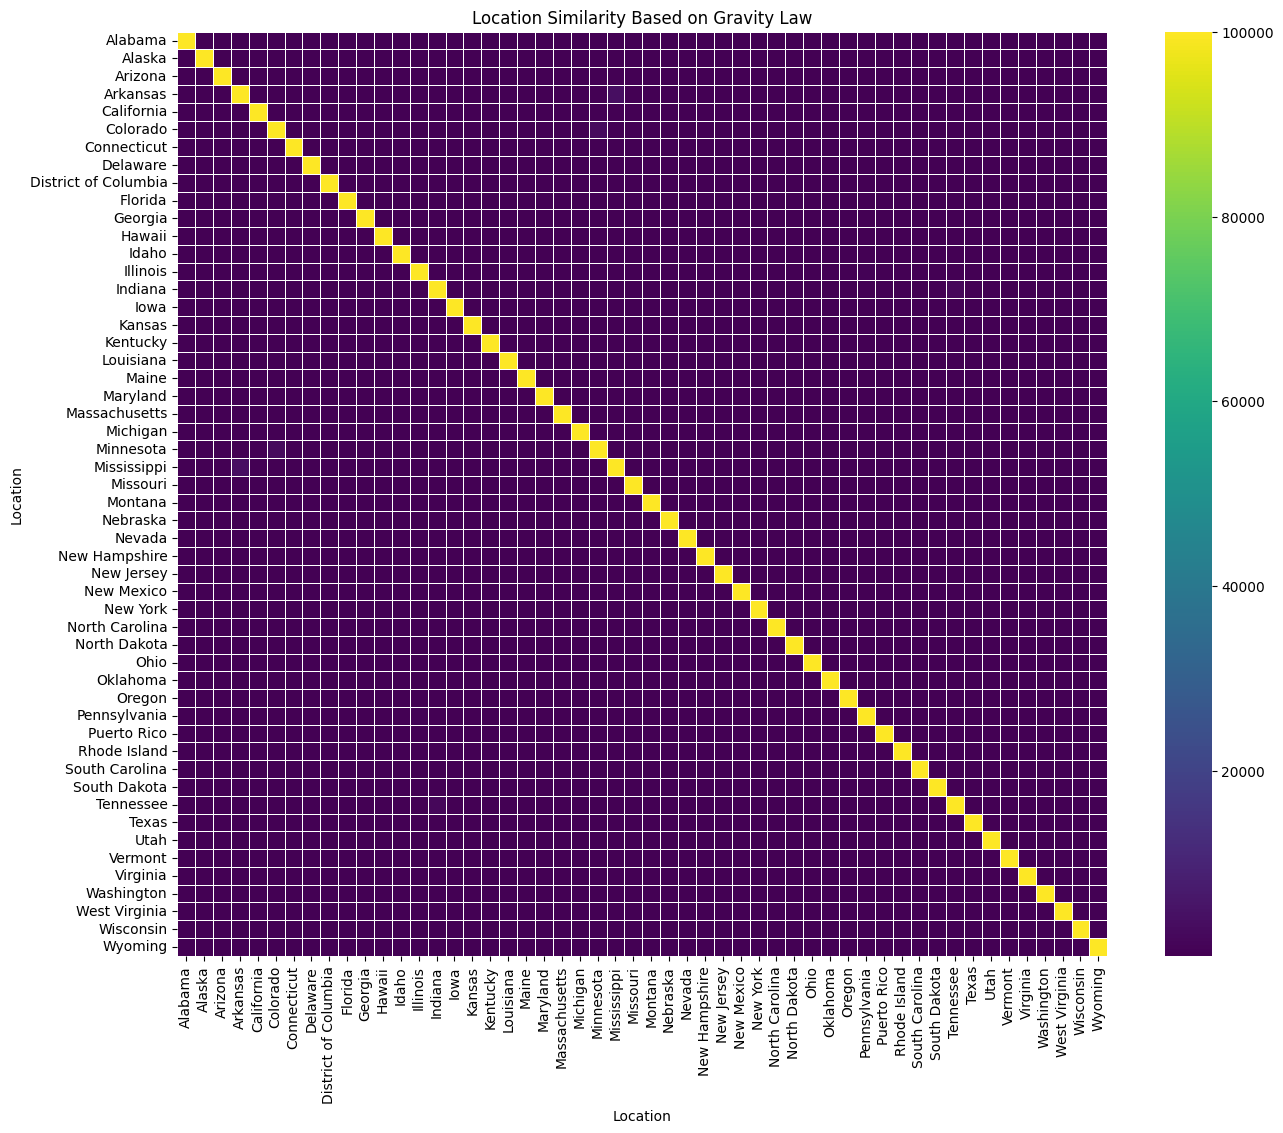

Adjacency Matrix Shape: torch.Size([52, 52])


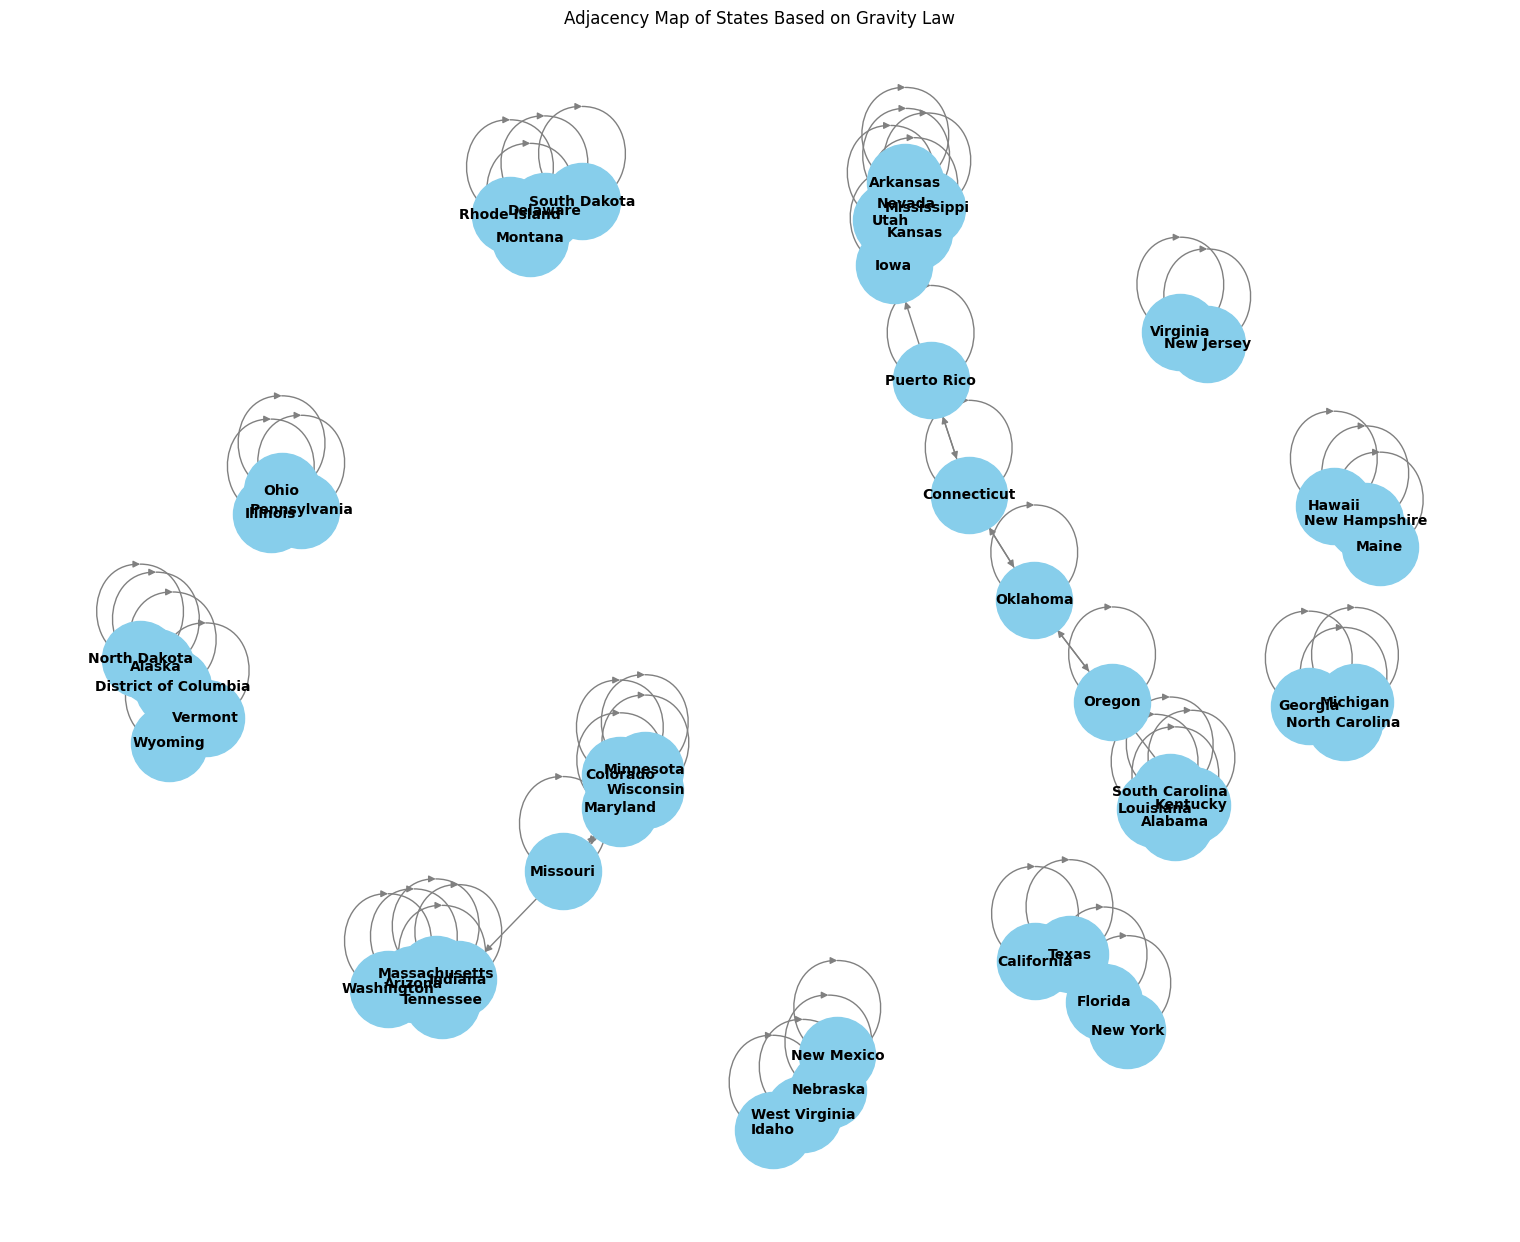

Training Epochs:   0%|          | 0/50 [00:01<?, ?it/s]

Error during forward pass: too many dimensions 'str'


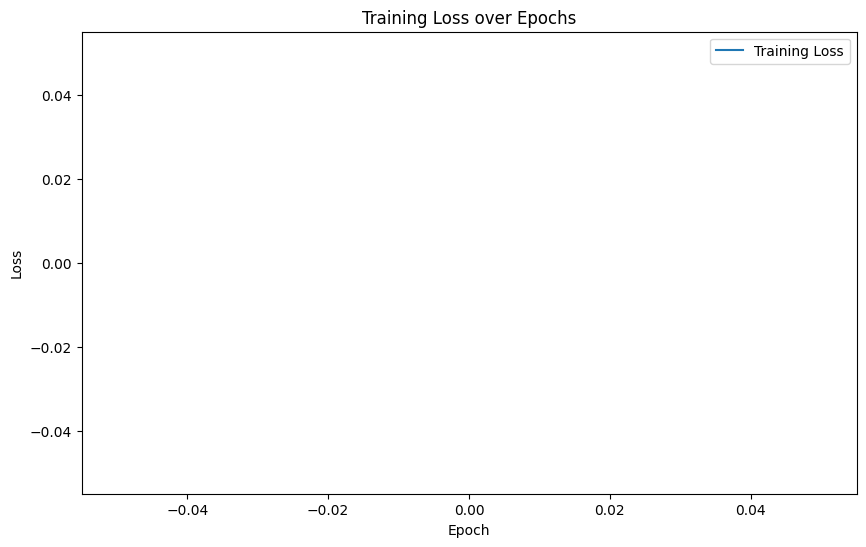

RuntimeError: Error(s) in loading state_dict for STAN:
	Missing key(s) in state_dict: "layer1.heads.0.fc.weight", "layer1.heads.0.fc.bias", "layer1.heads.0.attn_fc.weight", "layer1.heads.0.attn_fc.bias", "layer2.heads.0.fc.weight", "layer2.heads.0.fc.bias", "layer2.heads.0.attn_fc.weight", "layer2.heads.0.attn_fc.bias", "gru.weight_ih", "gru.weight_hh", "gru.bias_ih", "gru.bias_hh", "nn_res_I.weight", "nn_res_I.bias", "nn_res_R.weight", "nn_res_R.bias", "nn_res_sir.weight", "nn_res_sir.bias". 
	Unexpected key(s) in state_dict: "attention.in_proj_weight", "attention.in_proj_bias", "attention.out_proj.weight", "attention.out_proj.bias", "prediction.weight", "prediction.bias", "layer1.weight", "layer1.bias", "layer2.weight", "layer2.bias", "gru.weight_ih_l0", "gru.weight_hh_l0", "gru.bias_ih_l0", "gru.bias_hh_l0". 

In [1]:
# FILE: train_stan.ipynb

import os
import random
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from epiweeks import Week
from utils import date_today, gravity_law_commute_dist  # Ensure these are defined in utils.py
from model import STAN, CustomGraph  # Import STAN and CustomGraph from model.py

# Ensure reproducibility
RANDOM_SEED = 123
def seed_torch(seed=RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set environment variables
os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

# Load and merge data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
raw_data.to_csv('./data/state_covid_data.csv', index=False)
pop_data = pd.read_csv('./data/uszips.csv')
pop_data = pop_data.groupby('state_name').agg({
    'population':'sum',
    'density':'mean',
    'lat':'mean',
    'lng':'mean'
}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

# Generate location similarity based on Gravity Law
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state'] == each_loc]['lat'].unique()[0]
        lng1 = raw_data[raw_data['state'] == each_loc]['lng'].unique()[0]
        pop1 = raw_data[raw_data['state'] == each_loc]['population'].unique()[0]

        lat2 = raw_data[raw_data['state'] == each_loc2]['lat'].unique()[0]
        lng2 = raw_data[raw_data['state'] == each_loc2]['lng'].unique()[0]
        pop2 = raw_data[raw_data['state'] == each_loc2]['population'].unique()[0]

        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(
            lat1, lng1, pop1,
            lat2, lng2, pop2,
            r=0.5
        )

num_locations = len(loc_list)
print(f"Number of unique locations: {num_locations}")

# Convert loc_dist_map to a DataFrame for visualization
loc_dist_df = pd.DataFrame(loc_dist_map).fillna(0)

# Create a heatmap of location similarities
plt.figure(figsize=(15, 12))
sns.heatmap(loc_dist_df, cmap='viridis', linewidths=.5)
plt.title('Location Similarity Based on Gravity Law')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()

# Generate Adjacency Map based on distance threshold
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}

adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

# Initialize adjacency matrix
num_states = len(loc_list)
adj_matrix = np.zeros((num_states, num_states), dtype=np.float32)

# Create a mapping from state to index
state_to_index = {state: idx for idx, state in enumerate(loc_list)}

# Populate adjacency matrix based on adj_map
for each_loc in adj_map:
    i = state_to_index[each_loc]
    for each_loc2 in adj_map[each_loc]:
        j = state_to_index[each_loc2]
        adj_matrix[i][j] = 1  # Binary adjacency; set to 1 if connected

# Add self-loops to the adjacency matrix
adj_matrix += np.eye(num_states, dtype=np.float32)

# Normalize adjacency matrix
adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)

# Convert adjacency matrix to tensor
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32).to(device)
print(f"Adjacency Matrix Shape: {adj_matrix.shape}")

# Create a directed graph using NetworkX
G_nx = nx.DiGraph()

# Add nodes
for state in adj_map.keys():
    G_nx.add_node(state)

# Add edges
for state, neighbors in adj_map.items():
    for neighbor in neighbors:
        G_nx.add_edge(state, neighbor)

# Plot the adjacency graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G_nx, seed=RANDOM_SEED)  # For consistent layout
nx.draw(
    G_nx,
    pos,
    with_labels=True,
    node_size=3000,
    node_color='skyblue',
    font_size=10,
    font_weight='bold',
    edge_color='gray'
)
plt.title('Adjacency Map of States Based on Gravity Law')
plt.show()

# Initialize CustomGraph
custom_g = CustomGraph(G_nx, device)

# Preprocess features
active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for each_loc in loc_list:
    active = raw_data[raw_data['state'] == each_loc]['active'].values
    confirmed = raw_data[raw_data['state'] == each_loc]['confirmed'].values
    new = raw_data[raw_data['state'] == each_loc]['new_cases'].values
    deaths = raw_data[raw_data['state'] == each_loc]['deaths'].values
    static = raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']].values
    active_cases.append(active)
    confirmed_cases.append(confirmed)
    new_cases.append(new)
    death_cases.append(deaths)
    static_feat.append(static)

active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Compute differences for dynamic features
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases, axis=1)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases, axis=1)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases, axis=1)), axis=-1)

# Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

# Prepare data for training, validation, and testing
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape: n_loc, timestep, n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]

    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i + history_window + pred_window - 1 >= timestep or i + history_window >= timestep:
            break
        x.append(data[:, i:i + history_window, :].reshape((n_loc, history_window * n_feat)))

        concat_I.append(data[:, i + history_window - 1, 0])
        concat_R.append(data[:, i + history_window - 1, 1])
        last_I.append(sum_I[:, i + history_window - 1])
        last_R.append(sum_R[:, i + history_window - 1])

        y_I.append(data[:, i + history_window:i + history_window + pred_window, 0])
        y_R.append(data[:, i + history_window:i + history_window + pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

valid_window = 25
test_window = 25

history_window = 6
pred_window = 15
slide_step = 5

normalize = True

dynamic_feat = np.concatenate(
    (
        np.expand_dims(dI, axis=-1),
        np.expand_dims(dR, axis=-1),
        np.expand_dims(dS, axis=-1)
    ),
    axis=-1
)

# Normalize dynamic features
if normalize:
    for i, each_loc in enumerate(loc_list):
        dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
        dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
        dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

# Split data into train, validation, and test sets
train_feat = dynamic_feat[:, :-valid_window - test_window, :]
val_feat = dynamic_feat[:, -valid_window - test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(
    train_feat,
    active_cases[:, :-valid_window - test_window],
    recovered_cases[:, :-valid_window - test_window],
    history_window,
    pred_window,
    slide_step
)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(
    val_feat,
    active_cases[:, -valid_window - test_window:-test_window],
    recovered_cases[:, -valid_window - test_window:-test_window],
    history_window,
    pred_window,
    slide_step
)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(
    test_feat,
    active_cases[:, -test_window:],
    recovered_cases[:, -test_window:],
    history_window,
    pred_window,
    slide_step
)

# Initialize the STAN model
model = STAN(
    custom_g,
    in_dim=3 * history_window,
    hidden_dim1=32,
    hidden_dim2=32,
    gru_dim=32,
    num_heads=1,
    pred_window=pred_window,
    device=device
).to(device)

# Define optimizer and loss criterion
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

# Convert data to tensors and move to device
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_I = torch.tensor(train_I, dtype=torch.float32).to(device)
train_R = torch.tensor(train_R, dtype=torch.float32).to(device)
train_cI = torch.tensor(train_cI, dtype=torch.float32).to(device)
train_cR = torch.tensor(train_cR, dtype=torch.float32).to(device)
train_yI = torch.tensor(train_yI, dtype=torch.float32).to(device)
train_yR = torch.tensor(train_yR, dtype=torch.float32).to(device)

val_x = torch.tensor(val_x, dtype=torch.float32).to(device)
val_I = torch.tensor(val_I, dtype=torch.float32).to(device)
val_R = torch.tensor(val_R, dtype=torch.float32).to(device)
val_cI = torch.tensor(val_cI, dtype=torch.float32).to(device)
val_cR = torch.tensor(val_cR, dtype=torch.float32).to(device)
val_yI = torch.tensor(val_yI, dtype=torch.float32).to(device)
val_yR = torch.tensor(val_yR, dtype=torch.float32).to(device)

test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
test_I = torch.tensor(test_I, dtype=torch.float32).to(device)
test_R = torch.tensor(test_R, dtype=torch.float32).to(device)
test_cI = torch.tensor(test_cI, dtype=torch.float32).to(device)
test_cR = torch.tensor(test_cR, dtype=torch.float32).to(device)
test_yI = torch.tensor(test_yI, dtype=torch.float32).to(device)
test_yR = torch.tensor(test_yR, dtype=torch.float32).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_std.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dR_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dR_std.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

# Training parameters
all_loss = []
file_name = './save/stan.pth'
min_loss = 1e10

loc_name = 'California'
cur_loc = loc_list.index(loc_name)

epoch_count = 50 if normalize else 300
scale = 0.1

# Create save directory if it doesn't exist
os.makedirs('./save/', exist_ok=True)

# Training loop
for epoch in tqdm(range(epoch_count), desc='Training Epochs'):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    try:
        active_pred, recovered_pred, phy_active, phy_recover, _ = model(
            train_x,
            train_cI[cur_loc],
            train_cR[cur_loc],
            N[cur_loc],
            train_I[cur_loc],
            train_R[cur_loc],
            torch.tensor(dI[cur_loc], dtype=torch.float32).to(device),
            torch.tensor(dR[cur_loc], dtype=torch.float32).to(device),
            h=None
        )
    except Exception as e:
        print(f"Error during forward pass: {e}")
        break

    # Normalize if required
    if normalize:
        phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]

    # Compute loss
    loss = (
        criterion(active_pred.squeeze(), train_yI[cur_loc].squeeze()) +
        criterion(recovered_pred.squeeze(), train_yR[cur_loc].squeeze()) +
        scale * criterion(phy_active.squeeze(), train_yI[cur_loc].squeeze()) +
        scale * criterion(phy_recover.squeeze(), train_yR[cur_loc].squeeze())
    )

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        try:
            # Forward pass on training data to get hidden state
            _, _, _, _, prev_h = model(
                train_x,
                train_cI[cur_loc],
                train_cR[cur_loc],
                N[cur_loc],
                train_I[cur_loc],
                train_R[cur_loc],
                torch.tensor(dI[cur_loc], dtype=torch.float32).to(device),
                torch.tensor(dR[cur_loc], dtype=torch.float32).to(device),
                h=None
            )
            # Forward pass on validation data using previous hidden state
            val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(
                val_x,
                val_cI[cur_loc],
                val_cR[cur_loc],
                N[cur_loc],
                val_I[cur_loc],
                val_R[cur_loc],
                torch.tensor(dI[cur_loc], dtype=torch.float32).to(device),
                torch.tensor(dR[cur_loc], dtype=torch.float32).to(device),
                h=prev_h
            )
        except Exception as e:
            print(f"Error during validation pass: {e}")
            break

        if normalize:
            val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
            val_phy_recover = (val_phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]

        val_loss = (
            criterion(val_active_pred.squeeze(), val_yI[cur_loc].squeeze()) +
            criterion(val_recovered_pred.squeeze(), val_yR[cur_loc].squeeze()) +
            scale * criterion(val_phy_active.squeeze(), val_yI[cur_loc].squeeze()) +
            scale * criterion(val_phy_recover.squeeze(), val_yR[cur_loc].squeeze())
        )

    # Save the model if validation loss has decreased
    if val_loss.item() < min_loss:
        state = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss.item()

    # Print loss every epoch
    print(f"Epoch {epoch+1}/{epoch_count}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(all_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Load the best model
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

# Make predictions with the test set
prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_dI = torch.cat((torch.tensor(dI, dtype=torch.float32).to(device), torch.tensor(dI, dtype=torch.float32).to(device)), dim=1)
prev_dR = torch.cat((torch.tensor(dR, dtype=torch.float32).to(device), torch.tensor(dR, dtype=torch.float32).to(device)), dim=1)

# Forward pass using combined train and validation data to get hidden state
prev_active_pred, _, prev_phyactive_pred, _, h = model(
    prev_x,
    train_cI[cur_loc],
    train_cR[cur_loc],
    N[cur_loc],
    prev_I[cur_loc],
    prev_R[cur_loc],
    prev_dI[cur_loc],
    prev_dR[cur_loc],
    h=None
)

# Forward pass on test set using the hidden state
test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(
    test_x,
    test_cI[cur_loc],
    test_cR[cur_loc],
    N[cur_loc],
    test_I[cur_loc],
    test_R[cur_loc],
    torch.tensor(dI[cur_loc], dtype=torch.float32).to(device),
    torch.tensor(dR[cur_loc], dtype=torch.float32).to(device),
    h
)

if normalize:
    print(f'Estimated alpha in SIR model: {model.alpha_scaled.item():.4f}')
    print(f'Estimated beta in SIR model: {model.beta_scaled.item():.4f}')

# Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    if normalize:
        cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    else:
        cur_pred = test_pred_active[0, i, :].detach().cpu().numpy()
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)

# Function to get real y values
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape: n_loc, timestep, n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]

    y = []
    for i in range(0, timestep, slide_step):
        if i + history_window + pred_window - 1 >= timestep or i + history_window >= timestep:
            break
        y.append(data[:, i + history_window:i + history_window + pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

# Plot predictions vs true values for Active Cases
plt.figure(figsize=(12, 6))
plt.plot(I_true[cur_loc, -1, :], c='r', label='Ground truth')
plt.plot(pred_I[-1, :], c='b', label='Prediction')
plt.xlabel('Time Step')
plt.ylabel('Active Cases')
plt.title('Active Cases: True vs Predicted')
plt.legend()
plt.show()